# This notebook has codes to embed only the NIST species in the CDC SBRL data 
## Embedding 1: sugar tests as features for embedding
## Embedding 2: binary test features for embedding

In [2]:
import sys
sys.path.append("../..")
import pandas as pd
import numpy as np
import seaborn as sns
from src.preprocessing.load_cdc_data import sbrl_preprocess
from src.models.NN_embedding import *
from src.models.baseline_ML_functions import common_name_to_genus_speices
from sys import platform 
prefix = '../../data_files/'
prefixG = '/Volumes/GoogleDrive'
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size':18})
%matplotlib inline
%load_ext autoreload
%autoreload 2

2023-02-14 20:38:46.839777: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
phenotypic_data_confirmed = sbrl_preprocess()

In [4]:
len(phenotypic_data_confirmed)

12761

# Embedding 1: sugar fermentation tests

In [5]:
cols_to_use = ['Glu-F','Xyl-F','Man-F','Lact-F','Suc-F','Malt-F','TSI:S/B = Butt', 'TSI:S/B = Slant']
index_to_keep = phenotypic_data_confirmed[phenotypic_data_confirmed[cols_to_use].isna().sum(axis = 1) == 0].index
cdc_short = phenotypic_data_confirmed.loc[index_to_keep,cols_to_use]
cdc_short['final_id_clean'] = phenotypic_data_confirmed.loc[index_to_keep,'final_id_clean']
cdc_short = cdc_short.reset_index(drop = True)

In [6]:
# manually selected most abundant instances that have both genus and species present
abundant_species = ['haemophilus aphrophilus', 'pseudomonas maltophilia', 'capnocytophaga canimorsus [df-2]', 'eikenella corrodens [hb-1]',
                    'pseudomonas aeruginosa', 'vibrio parahaemolyticus']

In [9]:
# Reporter assay with all 40 IVV strains
all_IVV_df = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter/NN_all_IVV.csv')

In [10]:
name_mapping = common_name_to_genus_speices()
all_IVV_df['genus_species'] = all_IVV_df['Common Name'].map(name_mapping)
# get common genus + species if the NA rows are dropped
ivv_species_drop_na = list(set(cdc_short['final_id_clean'].unique()).intersection(set(all_IVV_df['genus_species'].unique())))

In [11]:
## combine the abundant species + NIST strains for embedding
## Using NIST strains alone don't aggregate well. Maybe not enough instances

In [12]:
ivv_n_abundant = cdc_short[cdc_short['final_id_clean'].isin(abundant_species + ivv_species_drop_na)]
ivv_n_abundant.reset_index(drop = True, inplace = True)
print(ivv_n_abundant.final_id_clean.unique().shape)

(19,)


In [13]:
encoded_cols = []
for col in ivv_n_abundant.columns[:-1]:
    encoded_cols.append(le.fit_transform(ivv_n_abundant[col]))

In [14]:
# Encode the ID to use as the labels
ivv_n_abundant = ivv_n_abundant.assign(encoded_final_id_clean = le.fit_transform(ivv_n_abundant['final_id_clean']))
y_one_hot=to_categorical(ivv_n_abundant.encoded_final_id_clean) 
train_index, test_index = train_test_split(ivv_n_abundant.index, test_size=0.2)

In [15]:
model = emb_model(encoded_cols, y_one_hot.shape[1])
history = model.fit([encoded_cols[i][train_index] for i in range(8)], y_one_hot[train_index], batch_size = 32, epochs = 45, verbose = 0)

2023-02-14 20:39:21.798159: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


10/10 [==============================] - 0s 10ms/step - loss: 0.4591 - accuracy: 0.9014


Text(0, 0.5, 'Accuracy')

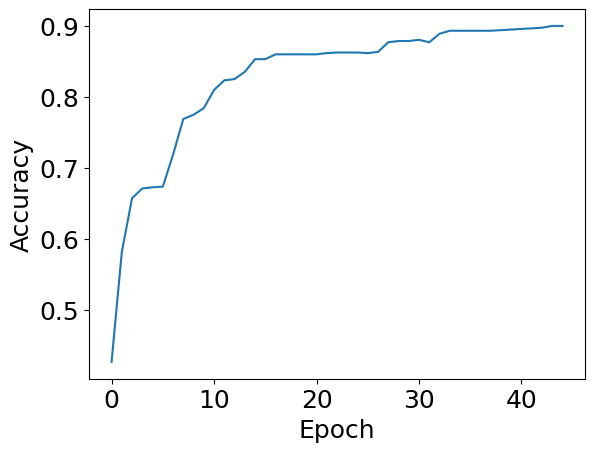

In [16]:
model.evaluate([encoded_cols[i][test_index] for i in range(8)],y_one_hot[test_index])
plt.plot(history.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [17]:
evaluate_NN(model, [encoded_cols[i][test_index] for i in range(len(encoded_cols))], y_one_hot[test_index])

10/10 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        50
           3       0.00      0.00      0.00         1
           4       1.00      0.95      0.97        38
           5       0.00      0.00      0.00         1
           6       1.00      0.33      0.50         6
           7       0.89      1.00      0.94        58
           9       1.00      0.67      0.80        27
          10       0.83      0.96      0.89        54
          12       0.40      0.80      0.53         5
          13       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         5
          16       0.96      0.88      0.92        25
          17       0.80      1.00      0.89        16
          18       1.00      1.00      1.00         7

    accuracy                           0.90       294
   macro avg       0.63      0.61      0.60       294
weighted avg       0.89    

In [18]:
pre_train_concat, umap_pre_train = embed_features_no_model(encoded_cols, 1)

In [19]:
ivv_n_abundant.final_id_clean.value_counts()

haemophilus aphrophilus             379
pseudomonas maltophilia             299
capnocytophaga canimorsus [df-2]    207
eikenella corrodens [hb-1]          163
pseudomonas aeruginosa              121
vibrio parahaemolyticus             117
yersinia enterocolitica              64
serratia marcescens                  39
yersinia pseudotuberculosis          27
escherichia coli                     23
staphylococcus epidermidis           12
corynebacterium diphtheriae           5
enterococcus faecalis                 4
listeria monocytogenes                3
serratia rubidaea                     3
bacillus cereus                       1
corynebacterium amycolatum            1
staphylococcus aureus                 1
pseudomonas putida                    1
Name: final_id_clean, dtype: int64

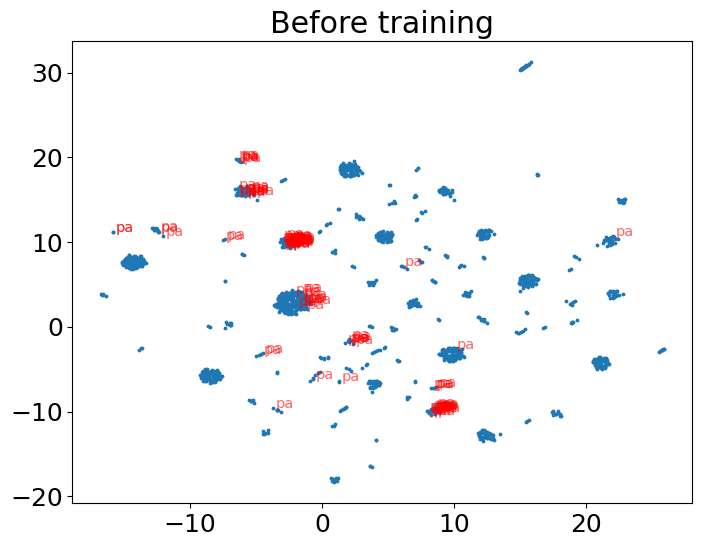

In [20]:
pa_index = ivv_n_abundant[ivv_n_abundant.final_id_clean == 'pseudomonas aeruginosa'].index
plot_emb_features(umap_pre_train, pa_index, title = 'Before training', annotation = 'pa')

46/46 [==============================] - 0s 4ms/step


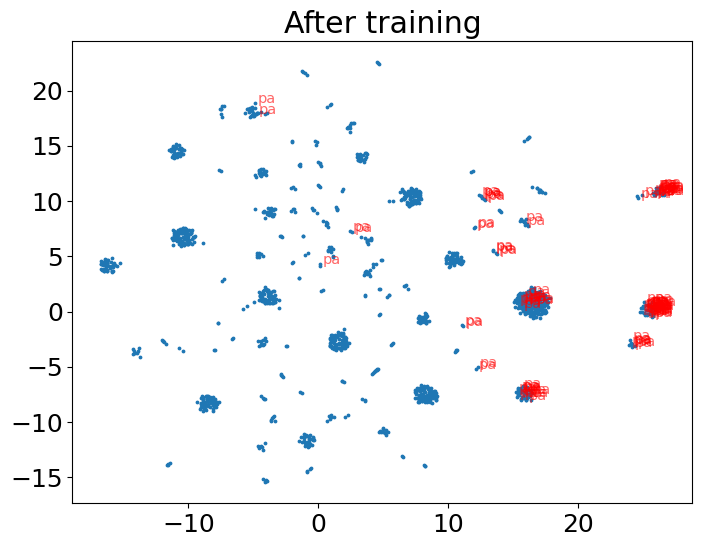

In [21]:
post_train_dense, post_train_emb = umap_emb_model_output(model, model.layers[-2].name, encoded_cols)
plot_emb_features(post_train_emb, pa_index, title = 'After training', annotation = 'pa')

## The 2 cells below are for making figures in the manuscript

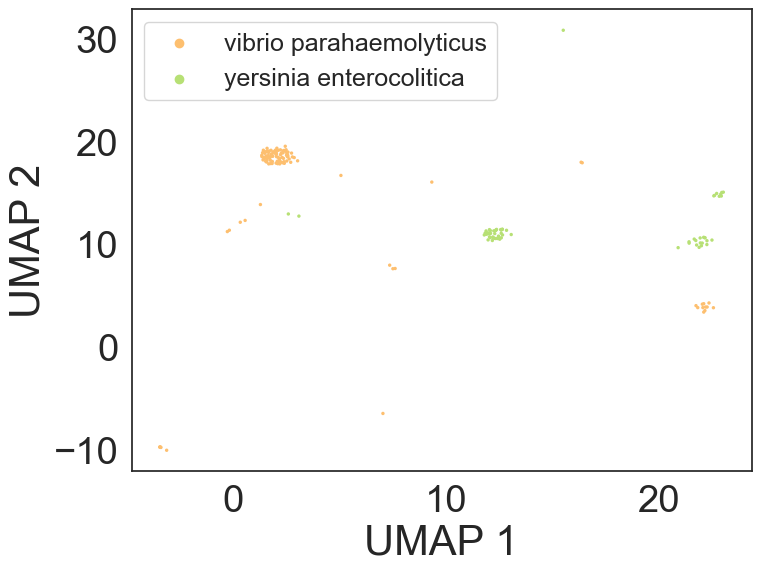

In [22]:
plot_emb_species(umap_pre_train, ivv_n_abundant, ['yersinia enterocolitica','vibrio parahaemolyticus'])

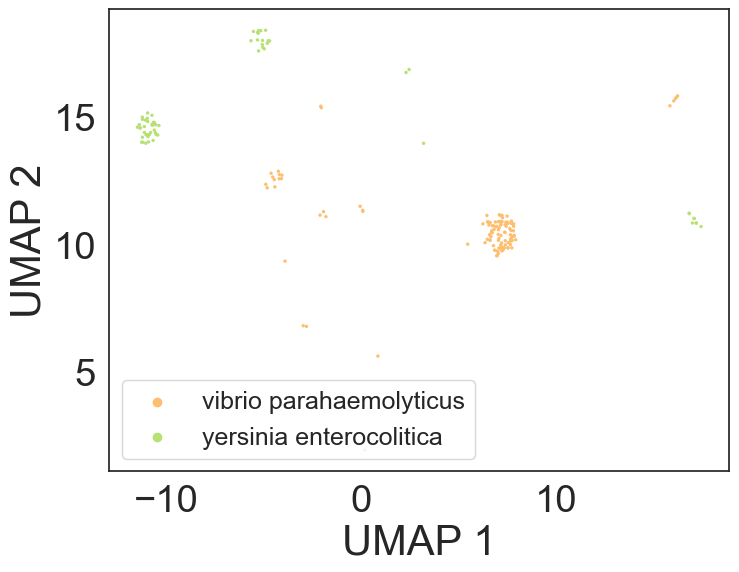

In [23]:
plot_emb_species(post_train_emb, ivv_n_abundant, ['yersinia enterocolitica','vibrio parahaemolyticus'])

## Quantify the clustering difference

In [24]:
quantify_clustering(ivv_n_abundant, pre_train_concat, post_train_dense)

,Before,After
NMI,0.66,0.75
RAND,0.89,0.91


In [25]:
post_train_df = pd.DataFrame(post_train_dense)
post_train_df['final_id_clean'] = ivv_n_abundant['final_id_clean']
post_train_mean = post_train_df.groupby('final_id_clean').mean() # aggregate the values so 1 value per species
post_train_mean.to_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_post_train_emb.csv')

# Embedding 2: binary features

In [26]:
clean_valid_genus_species = pd.read_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_genus_species_valid_data.csv')

In [27]:
features_to_use = clean_valid_genus_species.columns[:-2]
print(features_to_use)

Index(['MaC/SS = SS', 'MacC/SS = MacC', 'TSI:H2S =paper', 'TSI:H2S = butt', 'Cat', 'O', 'TSI:S/B = Slant', 'TSI:S/B = Butt'], dtype='object')


In [28]:
index_to_keep = phenotypic_data_confirmed[phenotypic_data_confirmed[features_to_use].isna().sum(axis = 1) == 0].index
cdc_short3 = phenotypic_data_confirmed.loc[index_to_keep,features_to_use]
cdc_short3['final_id_clean'] = phenotypic_data_confirmed.loc[index_to_keep,'final_id_clean']
cdc_short3 = cdc_short3.reset_index(drop = True)

In [30]:
# Reporter assay with all 40 IVV strains
all_IVV_df = pd.read_csv(prefixG+ '/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/reporter/NN_all_IVV.csv')

In [31]:
name_mapping = common_name_to_genus_speices()
all_IVV_df['genus_species'] = all_IVV_df['Common Name'].map(name_mapping)
# get common genus + species if the NA rows are dropped
ivv_species_drop_na2 = list(set(cdc_short3['final_id_clean'].unique()).intersection(set(all_IVV_df['genus_species'].unique())))

In [32]:
## combine the abundant species + NIST strains for embedding
## Using NIST strains alone don't aggregate well. Maybe not enough instances

In [33]:
ivv_n_abundant3 = cdc_short3[cdc_short3['final_id_clean'].isin(abundant_species + ivv_species_drop_na2)]
ivv_n_abundant3.reset_index(drop = True, inplace = True)

In [34]:
encoded_cols3 = []
for col in ivv_n_abundant3.columns[:-1]:
    encoded_cols3.append(le.fit_transform(ivv_n_abundant3[col]))

In [35]:
# Encode the ID to use as the labels
ivv_n_abundant3 = ivv_n_abundant3.assign(encoded_final_id_clean = le.fit_transform(ivv_n_abundant3['final_id_clean']))
y_one_hot3=to_categorical(ivv_n_abundant3.encoded_final_id_clean) 
train_index3, test_index3 = train_test_split(ivv_n_abundant3.index, test_size=0.2)

In [36]:
model3 = emb_model(encoded_cols3, y_one_hot3.shape[1])
history3 = model3.fit([encoded_cols3[i][train_index3] for i in range(len(encoded_cols3))], y_one_hot3[train_index3], batch_size = 32, epochs = 30, verbose = 0)

13/13 [==============================] - 0s 12ms/step - loss: 0.4763 - accuracy: 0.8382


Text(0, 0.5, 'Accuracy')

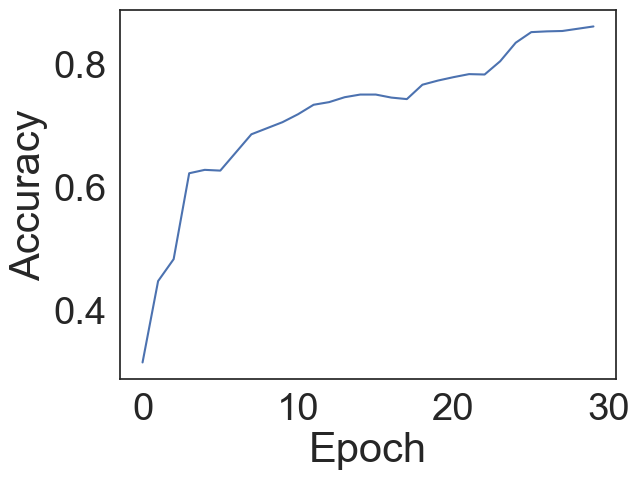

In [37]:
model3.evaluate([encoded_cols3[i][test_index3] for i in range(len(encoded_cols3))],y_one_hot3[test_index3])
plt.plot(history3.history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

In [38]:
pre_train_concat3, pre_train_emb3 = embed_features_no_model(encoded_cols3, 1)
post_train_dense3, post_train_emb3 = umap_emb_model_output(model3, model3.layers[-2].name, encoded_cols3)

64/64 [==============================] - 0s 5ms/step


In [39]:
ivv_n_abundant3.final_id_clean = ivv_n_abundant3.final_id_clean.str.replace(' \[.*?\]', '').str.strip()

In [40]:
quantify_clustering(ivv_n_abundant3, pre_train_concat3, post_train_dense3)

,Before,After
NMI,0.67,0.73
RAND,0.88,0.92


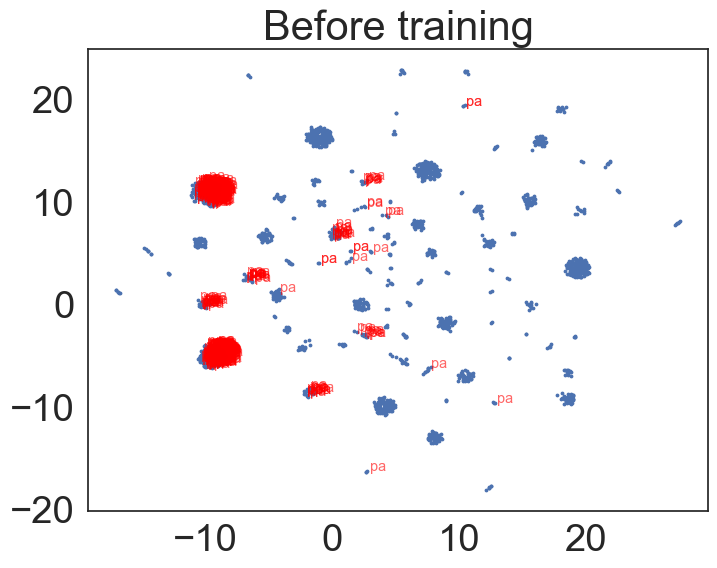

In [41]:
pa_index = ivv_n_abundant3[ivv_n_abundant3.final_id_clean == 'pseudomonas aeruginosa'].index
plot_emb_features(pre_train_emb3, pa_index, title = 'Before training', annotation = 'pa')

64/64 [==============================] - 0s 5ms/step


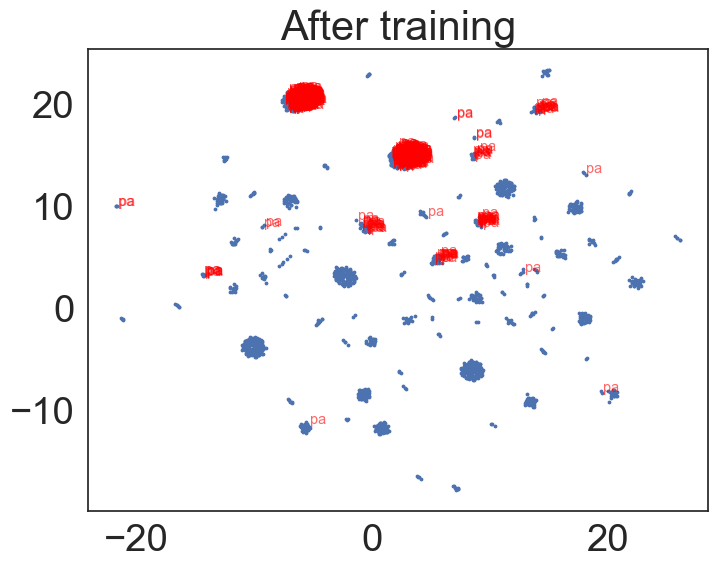

In [42]:
post_train_dense3, post_train_emb3 = umap_emb_model_output(model3, model3.layers[-2].name, encoded_cols3)
plot_emb_features(post_train_emb3, pa_index, title = 'After training', annotation = 'pa')

In [43]:
post_train_df3 = pd.DataFrame(post_train_dense3)
post_train_df3['final_id_clean'] = ivv_n_abundant3['final_id_clean']
post_train_mean3 = post_train_df3.groupby('final_id_clean').mean()
post_train_mean3.to_csv(prefixG+'/Shared drives/STTR_Netrias/Phase II/data/cdc sbrl/cdc_post_train_emb2.csv')

## Confusion matrix for after training

In [44]:
from sklearn.metrics import confusion_matrix as cm
prediction = model3.predict([encoded_cols3[i][test_index3] for i in range(len(encoded_cols3))])
labels = ivv_n_abundant3['final_id_clean'].unique()
cm_result = cm(ivv_n_abundant3['final_id_clean'][test_index3].values, le.inverse_transform(np.argmax(prediction, axis = 1)), normalize='true', labels = labels)

13/13 [==============================] - 0s 6ms/step


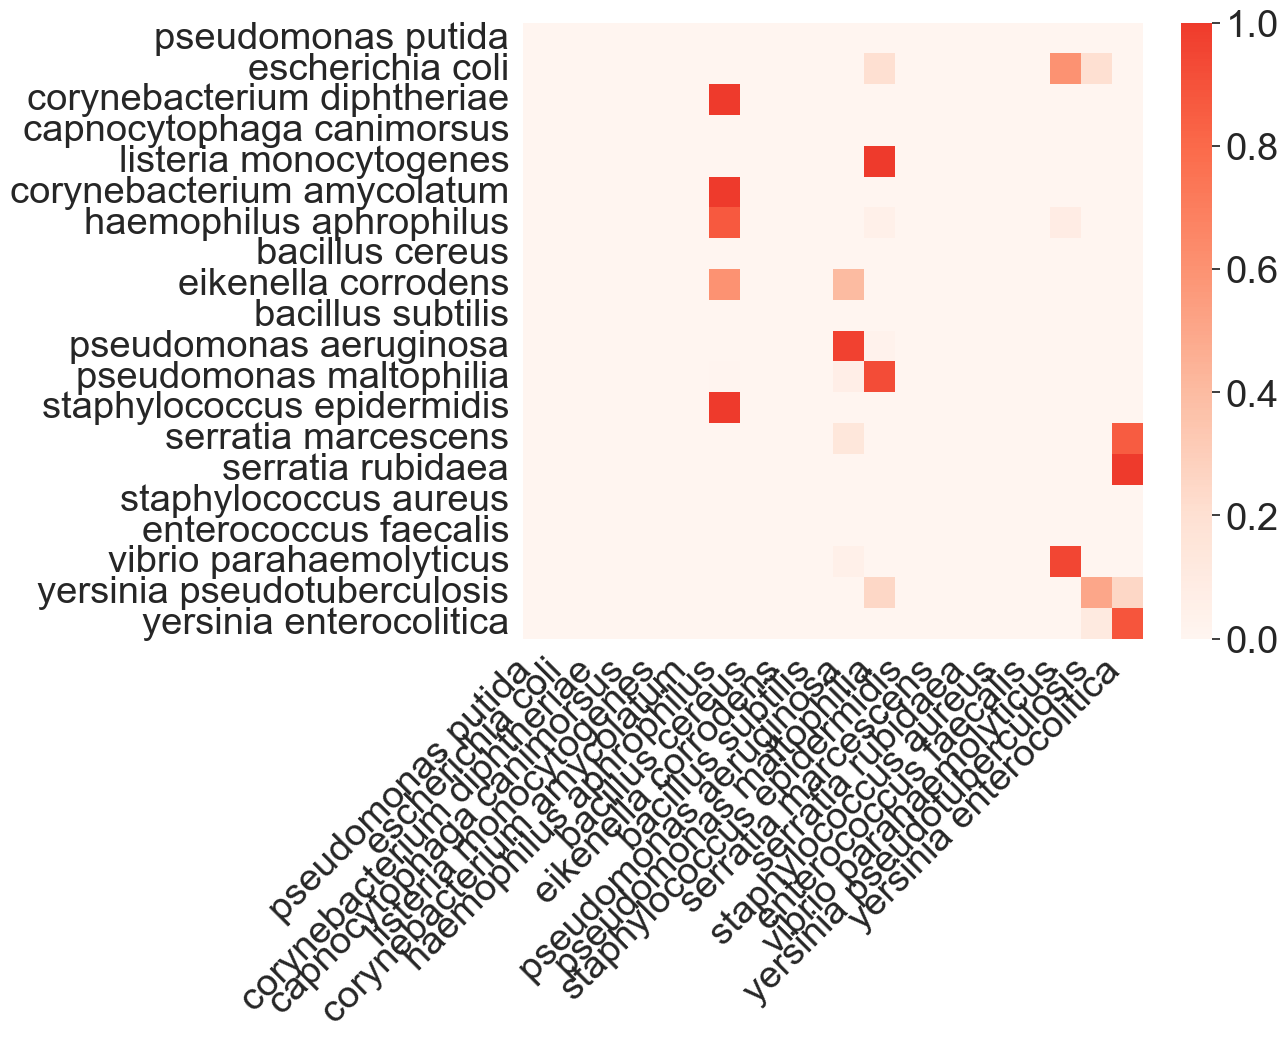

In [45]:
plt.rcParams.update({'font.size':18})
plt.figure(figsize=(10, 8))
sns.heatmap(cm_result, cmap = 'Reds', xticklabels=labels, yticklabels=labels, center = 0.8)
plt.xticks(rotation=45, ha = 'right');

In [46]:
test_set_abundant_only = ivv_n_abundant3['final_id_clean'][test_index3][ivv_n_abundant3['final_id_clean'][test_index3].isin(abundant_species)].index

In [47]:
predict_all = model3.predict([encoded_cols3[i] for i in range(len(encoded_cols3))])

64/64 [==============================] - 0s 6ms/step


In [48]:
cm_result_abundant_only = cm(ivv_n_abundant3['final_id_clean'][test_set_abundant_only].values, 
                             le.inverse_transform(np.argmax(predict_all[test_set_abundant_only], axis = 1)), normalize='true', labels = abundant_species)

In [49]:
ivv_n_abundant3[ivv_n_abundant3['final_id_clean'].isin(abundant_species)]['final_id_clean'].value_counts()

pseudomonas aeruginosa     544
pseudomonas maltophilia    502
haemophilus aphrophilus    348
vibrio parahaemolyticus    117
Name: final_id_clean, dtype: int64

In [50]:
# add the scores on the diagonal
annot = cm_result_abundant_only.copy()
for i in range(len(annot)):
    for j in range(len(annot)):
        if i != j:
            annot[i,j] = 0

In [51]:
annot = np.round(annot,2)
annot = annot.astype('str')
annot[annot=='0.0']=''

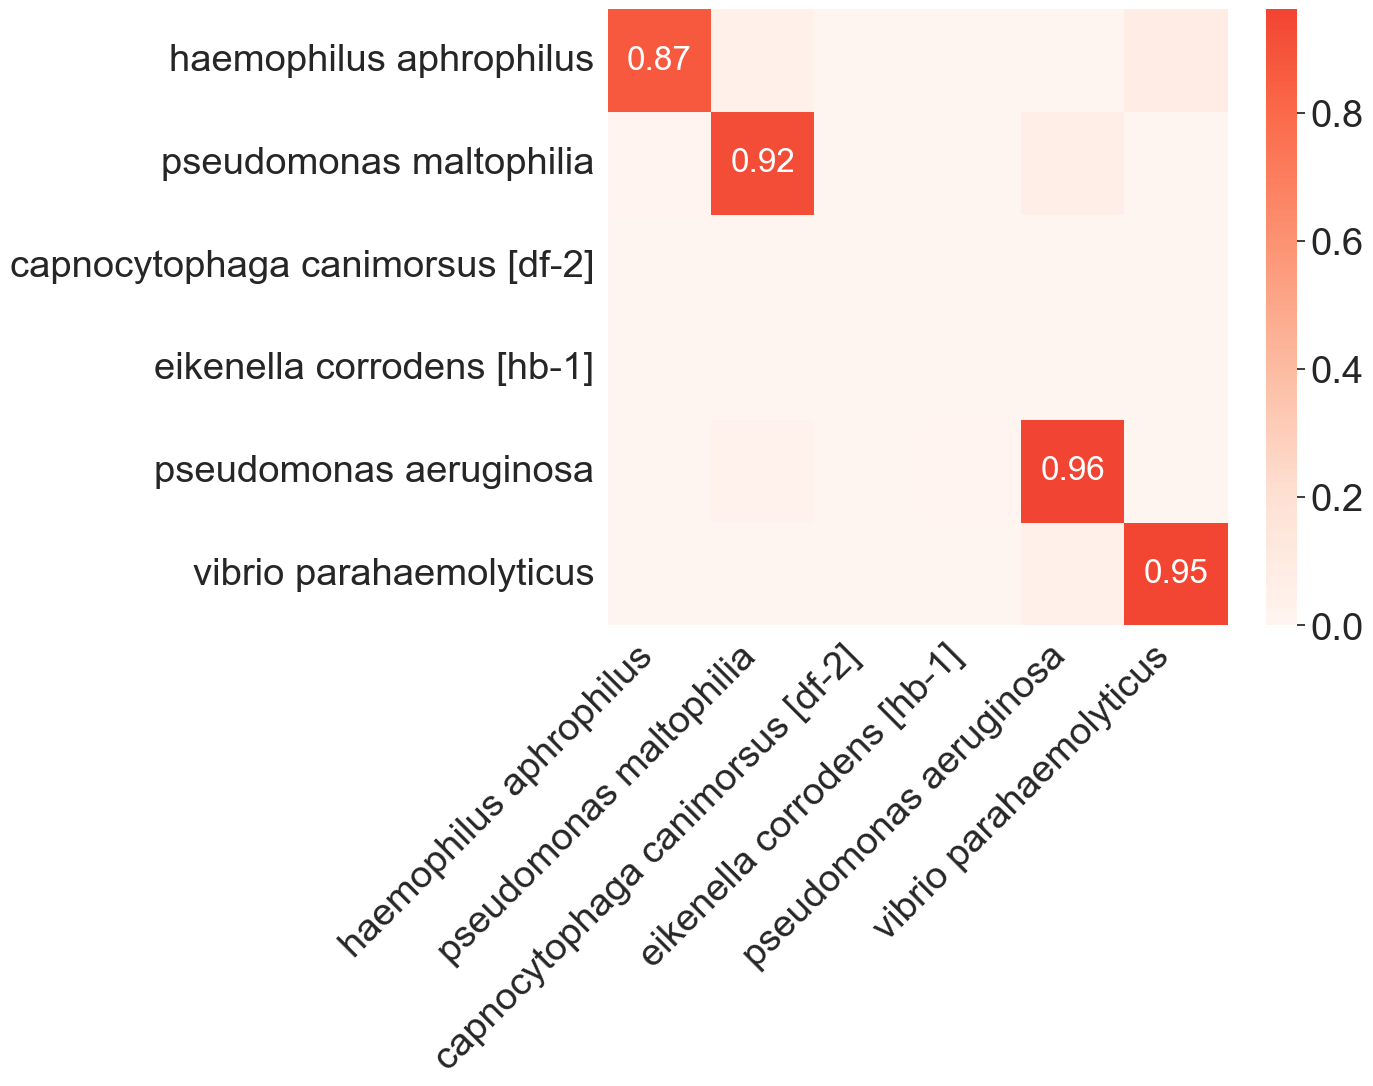

In [52]:
plt.rcParams.update({'font.size':24})
plt.figure(figsize=(10, 8))
sns.heatmap(cm_result_abundant_only, cmap = 'Reds', xticklabels=abundant_species, yticklabels=abundant_species, 
            annot = annot, fmt = '', center = 0.8)
plt.xticks(rotation=45, ha = 'right');